In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#to ignore warning when using append instead of concat
import warnings
warnings.filterwarnings('ignore')
import gc
from timeit import default_timer as timer

# Meta Data
* session_id - the ID of the session the event took place in
* index - the index of the event for the session
* elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
* event_name - the name of the event type
* name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
* level - what level of the game the event occurred in (0 to 22)
* page - the page number of the event (only for notebook-related events)
* room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
* room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
* screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
* screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
* hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
* text - the text the player sees during this event
* fqid - the fully qualified ID of the event
* room_fqid - the fully qualified ID of the room the event took place in
* text_fqid - the fully qualified ID of the
* fullscreen - whether the player is in fullscreen mode
* hq - whether the game is in high-quality
* music - whether the game music is on or off
* level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

In [2]:
# read in training data
#train = pd.read_csv('train.csv', dtype=dtypes)  
train = pd.read_csv('train.csv') # this takes a minute

# take a peek at the data ...
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0.0,0.0,cutscene_click,basic,0.0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0.0,0.0,1.0,0-4
1,20090312431273200,1.0,1323.0,person_click,basic,0.0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0.0,0.0,1.0,0-4
2,20090312431273200,2.0,831.0,person_click,basic,0.0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0.0,0.0,1.0,0-4
3,20090312431273200,3.0,1147.0,person_click,basic,0.0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0.0,0.0,1.0,0-4
4,20090312431273200,4.0,1863.0,person_click,basic,0.0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0.0,0.0,1.0,0-4


In [3]:
# ... and the tail
train.tail()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
15275593,21050410392475532,992.0,82289223.0,person_click,basic,20.0,NaN,180.671629,16.026063,587.0,295.0,NaN,"Well, get on it. I'm counting on you to figure...",boss,tunic.capitol_2.hall,tunic.capitol_2.hall.boss.haveyougotit,0.0,0.0,1.0,13-22
15275594,21050410392475532,993.0,82290873.0,navigate_click,undefined,20.0,NaN,-220.843582,-206.701209,322.0,442.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0.0,0.0,1.0,13-22
15275595,21050410392475532,994.0,82291372.0,navigate_click,undefined,20.0,NaN,-415.069110,-298.590468,212.0,501.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0.0,0.0,1.0,13-22
15275596,21050410392475532,995.0,82291756.0,navigate_click,undefined,20.0,NaN,-639.868123,-230.932862,88.0,452.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0.0,0.0,1.0,13-22
15275597,21050410392475532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# print the shape of the training data
print('The shape of the training data is ', train.shape)
print()
# print the dtypes
print('The data types of the columns are \n', train.dtypes)

The shape of the training data is  (15275598, 20)

The data types of the columns are 
 session_id          int64
index             float64
elapsed_time      float64
event_name         object
name               object
level             float64
page              float64
room_coor_x       float64
room_coor_y       float64
screen_coor_x     float64
screen_coor_y     float64
hover_duration    float64
text               object
fqid               object
room_fqid          object
text_fqid          object
fullscreen        float64
hq                float64
music             float64
level_group        object
dtype: object


Before we update these column data types, let's check if there is any missing data...

In [5]:
# print missing values
train.isnull().sum()

session_id               0
index                    1
elapsed_time             1
event_name               1
name                     1
level                    1
page              14950928
room_coor_x        1246862
room_coor_y        1246862
screen_coor_x      1246862
screen_coor_y      1246862
hover_duration    14069761
text               9728272
fqid               4805610
room_fqid                1
text_fqid          9728214
fullscreen               1
hq                       1
music                    1
level_group              1
dtype: int64

Interesting.. all the columns are missing one value. Let's see if they're all missing the same row...

In [6]:
# print is null rows for elapsed time
train[train['elapsed_time'].isnull()]

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
15275597,21050410392475532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Yep! At index 15275597 we have a missing value for all the columns! We can drop that row.

In [7]:
# drop that row
train.drop(train[train['elapsed_time'].isnull()].index, inplace=True)
train.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              14950927
room_coor_x        1246861
room_coor_y        1246861
screen_coor_x      1246861
screen_coor_y      1246861
hover_duration    14069760
text               9728271
fqid               4805609
room_fqid                0
text_fqid          9728213
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

Now we can update the row data types to be more appropriate. To save CPU space, we will follow the data types recommended by other Kaggle users!

In [8]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'
    }

# update the data types
train = train.astype(dtypes)

Looks good! But we are missing our target variable, so let's add that in.

# Load the labels
The labels for the training dataset are stored in the `train_labels.csv`. It consists of the information on whether the user in a particular session answered each question correctly which is our target variable.

In [9]:
labels = pd.read_csv('train_labels.csv')
labels.head()

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


Each value in the column `session_id` corresponds to the combination of both the session and question number. We will split these into individual columns for ease of use.

In [10]:
labels['session'] = labels.session_id.apply(lambda x : int(x.split('_')[0]))
labels['question'] = labels.session_id.apply(lambda x : int(x.split('_')[-1][1:]))
labels.head()

,session_id,correct,session,question
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [11]:
labels.dtypes

session_id    object
correct        int64
session        int64
question       int64
dtype: object

Our goal is to train models for each question to predict the label `correct` for any input user session.

# Exploratory Data Analysis

In [12]:
# print number of unique values for each column
train.nunique()

session_id          13598
index               20348
elapsed_time      4009696
event_name             11
name                    6
level                  23
page                    7
room_coor_x       7855274
room_coor_y       5951898
screen_coor_x       32693
screen_coor_y       45090
hover_duration      20141
text                  597
fqid                  128
room_fqid              19
text_fqid             126
fullscreen              2
hq                      2
music                   2
level_group             3
dtype: int64

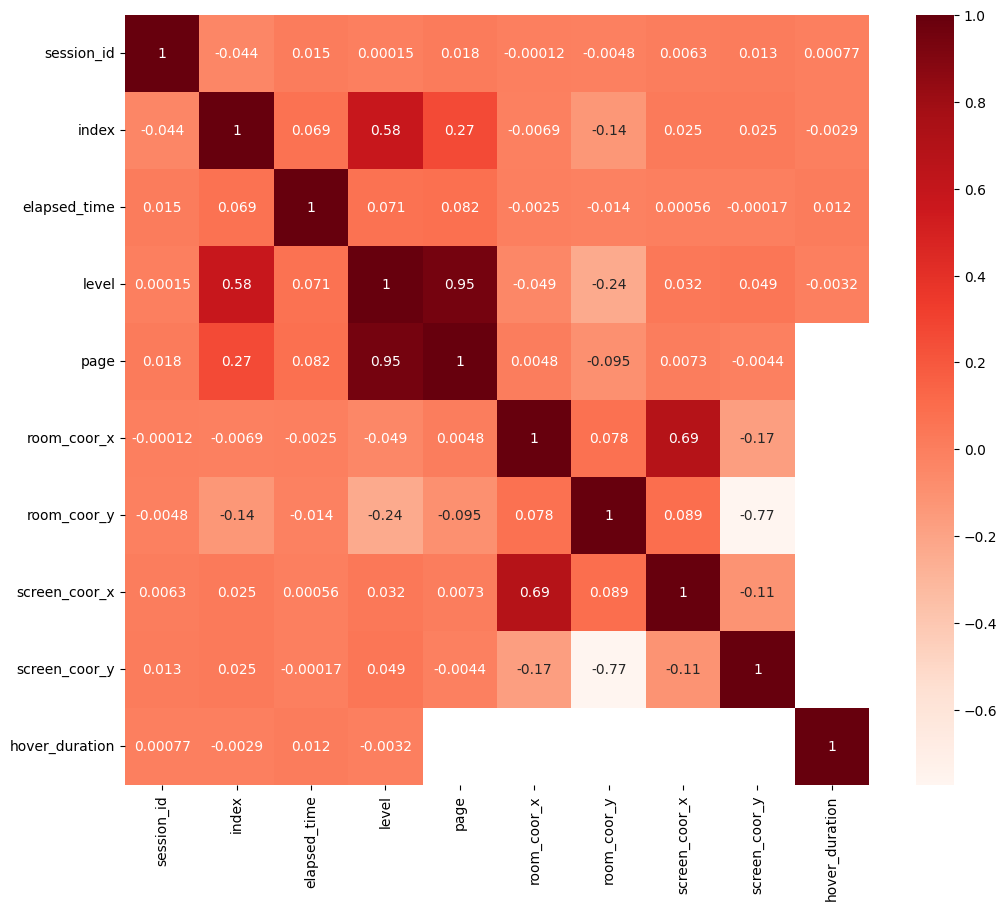

In [13]:
# let's see the correlation between our numerical features
corr = train.corr() 
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()


In [14]:
corr.style.background_gradient(cmap='coolwarm')

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
session_id,1.000000,-0.044391,0.014610,0.000150,0.018303,-0.000119,-0.004786,0.006342,0.013482,0.000774
index,-0.044391,1.000000,0.069110,0.583425,0.265490,-0.006909,-0.135487,0.024659,0.024938,-0.002884
elapsed_time,0.014610,0.069110,1.000000,0.071366,0.082121,-0.002518,-0.014204,0.000562,-0.000170,0.012096
level,0.000150,0.583425,0.071366,1.000000,0.949380,-0.048523,-0.237204,0.032063,0.048640,-0.003228
page,0.018303,0.265490,0.082121,0.949380,1.000000,0.004834,-0.094809,0.007307,-0.004388,nan
room_coor_x,-0.000119,-0.006909,-0.002518,-0.048523,0.004834,1.000000,0.077501,0.686521,-0.171277,nan
room_coor_y,-0.004786,-0.135487,-0.014204,-0.237204,-0.094809,0.077501,1.000000,0.089050,-0.772706,nan
screen_coor_x,0.006342,0.024659,0.000562,0.032063,0.007307,0.686521,0.089050,1.000000,-0.113875,nan
screen_coor_y,0.013482,0.024938,-0.000170,0.048640,-0.004388,-0.171277,-0.772706,-0.113875,1.000000,nan
hover_duration,0.000774,-0.002884,0.012096,-0.003228,nan,nan,nan,nan,nan,1.000000


In [15]:
# print highest correlations
print('The highest correlations are \n', corr.unstack().sort_values(kind='quicksort', ascending=False).drop_duplicates()[:20])

The highest correlations are 
 session_id      session_id       1.000000
level           page             0.949380
screen_coor_x   room_coor_x      0.686521
index           level            0.583425
                page             0.265490
screen_coor_x   room_coor_y      0.089050
elapsed_time    page             0.082121
room_coor_y     room_coor_x      0.077501
level           elapsed_time     0.071366
elapsed_time    index            0.069110
screen_coor_y   level            0.048640
level           screen_coor_x    0.032063
screen_coor_y   index            0.024938
index           screen_coor_x    0.024659
page            session_id       0.018303
session_id      elapsed_time     0.014610
screen_coor_y   session_id       0.013482
hover_duration  elapsed_time     0.012096
screen_coor_x   page             0.007307
session_id      screen_coor_x    0.006342
dtype: float64


Let's take a look at the distribution of our target variable.

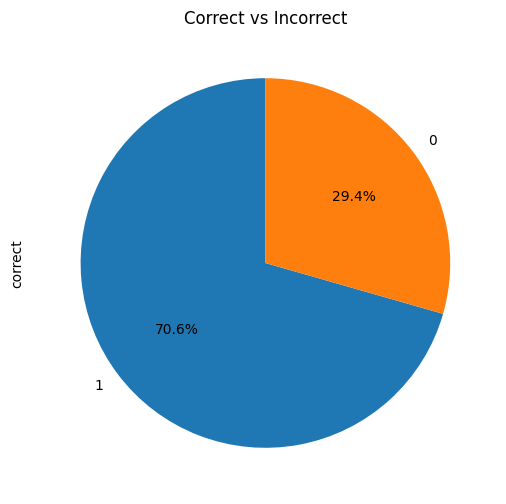

In [16]:
# pie plot of target variable
plt.figure(figsize=(6, 6))
labels.correct.value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
# add title
plt.title('Correct vs Incorrect')
plt.show()

From the above pie plot, we can see that the proportion of correct answers is much higher than incorrect answers. We will have to keep this in mind when we are training our models.

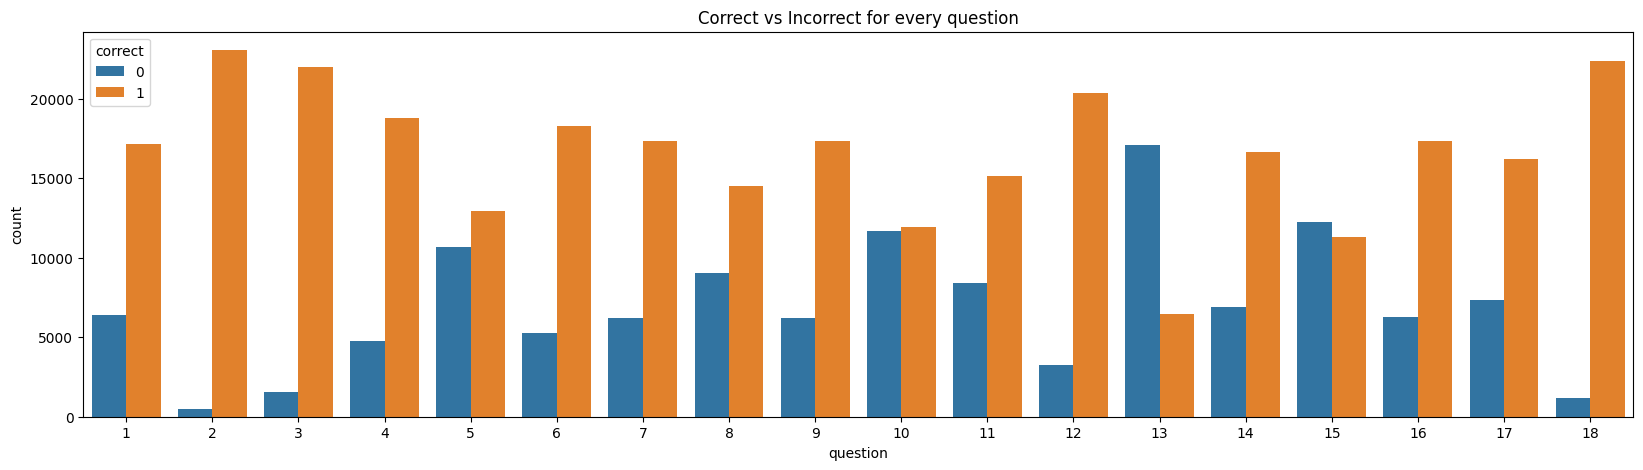

In [17]:
# bar chart of correct for every question
plt.figure(figsize=(20,5))
sns.countplot(x='question', hue='correct', data=labels)
plt.title('Correct vs Incorrect for every question')
plt.show()